In [1]:
import os
from pathlib import Path
import sys

if "__project_dir__" not in globals():
    __project_dir__ = Path.cwd().parent.resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [2]:
import json
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame

import seaborn as sns

sns.set_theme()

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"

In [3]:
MODELS = [
    "Beta_CDR3_Levenshtein",
    "Beta_CDR_Levenshtein",
    "Beta_tcrdist",
    "SCEPTR",
    "SCEPTR_finetuned",
    # "Beta_ML_tcrdist"
]

MODEL_NAME_TRANSLATOR = {
    "Beta_CDR3_Levenshtein": "Levenshtein (CDR3 only)",
    "Beta_CDR_Levenshtein": "Levenshtein",
    "Beta_tcrdist": "tcrdist",
    "SCEPTR": "SCEPTR",
    "SCEPTR_finetuned": "SCEPTR (fine-tuned)",
    # "Beta_ML_tcrdist": "ML tcrdist"
}

In [4]:
def read_precision_recall_results(model_name: str) -> dict:
    benchmarks_path = Path("/home/yutanagano/Projects/tcr_embedder/benchmarks")
    with open(benchmarks_path/model_name/"precision_recall"/"results.json", "r") as f:
        return json.load(f)

precision_recall_dict = {
    MODEL_NAME_TRANSLATOR[model_name]: read_precision_recall_results(model_name) for model_name in MODELS
}

In [10]:
def get_thresholds(data: dict, dataset_name: str) -> ndarray:
    return np.array(data[f"pr_stats_{dataset_name}"]["thresholds"])

def get_precisions(data: dict, dataset_name: str) -> ndarray:
    return np.array(data[f"pr_stats_{dataset_name}"]["precisions"])

def get_recalls(data: dict, dataset_name: str) -> ndarray:
    return np.array(data[f"pr_stats_{dataset_name}"]["recalls"])

def get_bg_discovery_rates(data: dict, dataset_name: str) -> ndarray:
    return np.array(data[f"pr_stats_{dataset_name}"]["background_discovery_rates"])

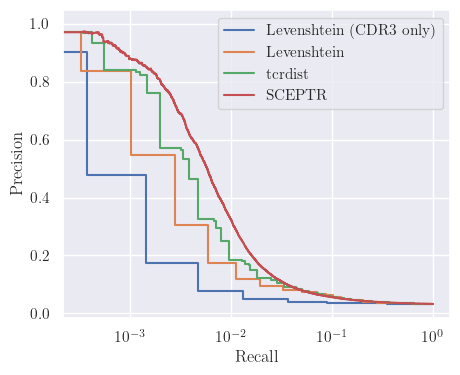

In [6]:
fig, ax = plt.subplots(figsize=(5,4))

for model_name, data in precision_recall_dict.items():
    if model_name == "SCEPTR (fine-tuned)":
        continue

    precision = get_precisions(data, "mira")
    recall = get_recalls(data, "mira")

    ax.step(recall, precision, label=model_name)

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xscale("log")
ax.legend()

fig.savefig("baseline_sceptr_benchmarking.pdf", dpi=300, bbox_inches="tight")

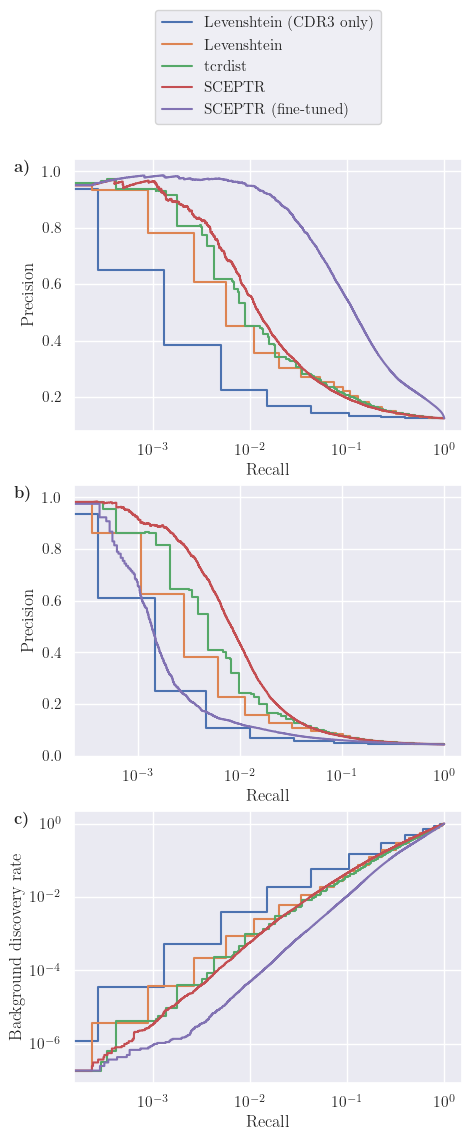

In [7]:
fig, axs = plt.subplots(nrows=3, figsize=(5,12))

for model_name, data in precision_recall_dict.items():
    cis_precisions = get_precisions(data, "mira_training_epitopes")
    cis_recalls = get_recalls(data, "mira_training_epitopes")

    trans_precisions = get_precisions(data, "mira_unseen_epitopes")
    trans_recalls = get_recalls(data, "mira_unseen_epitopes")

    cis_bg_discovery_rates = get_bg_discovery_rates(data, "mira_training_epitopes")

    axs[0].step(cis_recalls, cis_precisions, label=model_name)
    axs[1].step(trans_recalls, trans_precisions, label=model_name)
    axs[2].step(cis_recalls, cis_bg_discovery_rates, label=model_name)

for ax, label in zip(axs, ("a)", "b)", "c)")):
    ax.set_xscale("log")
    ax.set_xlabel("Recall")

    trans = matplotlib.transforms.ScaledTranslation(-60/100, 0, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, r"\textbf{" + label + "}", transform=ax.transAxes + trans,
            fontsize='medium', va='top', fontfamily='serif')

axs[0].set_ylabel("Precision")
axs[1].set_ylabel("Precision")
axs[2].set_yscale("log")
axs[2].set_ylabel("Background discovery rate")

axs[2].set_xlabel("Recall")

axs[0].legend(loc="lower center", bbox_to_anchor=(0,1.1,1,1))

fig.savefig("finetuned_sceptr_benchmarking.pdf", dpi=300, bbox_inches="tight")

In [13]:
similarity_thresholds = get_thresholds(precision_recall_dict["SCEPTR"], "mira")
precisions = get_precisions(precision_recall_dict["SCEPTR"], "mira")

In [21]:
filtered_precisions = precisions[np.log(similarity_thresholds) * -50 <= 1]

In [22]:
filtered_precisions

array([1.        , 0.97129187, 0.97142857, ..., 0.16025415, 0.15876622,
       0.15739844])